## **<h3 align="center"> Deep Learning - Project </h3>**
# **<h3 align="center">Preprocessing</h3>**
**Group 4 members:**<br>
Alexandra Pinto - 20211599@novaims.unl.pt - 20211599<br>
Steven Carlson - 20240554@novaims.unl.pt - 20240554<br>
Sven Goerdes - 20240503@novaims.unl.pt - 20240503<br>
Tim Straub - 20240505@novaims.unl.pt - 20240505<br>
Zofia Wojcik  - 20240654@novaims.unl.pt - 20240654<br>

# Table of Contents
* [1. Introduction](#intro)
* [2. Setup](#setup)
* [3. Data Loading and Exploration](#dataloadandexpl)
    * [3.1. Data Loading](#data_loading)
    * [3.2. Validating File Paths](#val_file_path)
    * [3.3. Checking for Missing or Duplicate Values](#NaN_and_duplicates)
    * [3.4. Visualization](#visualization)
* [4. General Image Preprocessing](#image_preproc)
    * [4.1. Visualization](#image_visualization)
    * [4.2. Image Duplicates](#image_duplicates)
    * [4.3. Channels](#image_channels)
    * [4.4. Text Recognition](#text_recognition)
    * [4.5. Human Recognition](#human_recognition)

* [5. Train Test Split](#train_test_split)


In [1]:
#we can also connect to drive and have the images there 

# 1. Introduction <a class="anchor" id="intro"></a>

This project focuses on developing a deep learning model to classify rare species based on images. The dataset comes from the Encyclopedia of Life (EOL) and is curated as part of the *BioCLIP: A Vision Foundation Model for the Tree of Life* study. The full study is available in our repository [here](<Project Description/BioCLIP_study.pdf>).  
In this notebook, we will focus on setting up the environment and preprocessing the data. This includes loading the dataset, exploring its structure, splitting it into training, validation, and test sets, and applying necessary image transformations. These steps are crucial for ensuring that the model is trained effectively and generalizes well to new data.  

# 2. Setup <a class="anchor" id="setup"></a>
In this section, we will import the necessary libraries that will be used throughout the notebook. These libraries will help with data handling and image processing.

In [ ]:
# Standard libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import zipfile
import seaborn as sns

# Libraries for image processing
from glob import glob
from PIL import Image
# pip install ImageHash
# import imagehash


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report



from tensorflow import TensorSpec
from tensorflow.keras.models import load_model


# Tensorflow for GPU
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))
from tensorflow.keras.callbacks import ModelCheckpoint

# import pipeline_methods.py methods
import sys
import importlib
import pipeline_methods
importlib.reload(pipeline_methods)
from pipeline_methods import *

TensorFlow version: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 3. Data Loading & Exploration <a class="anchor" id="dataloadandexpl"></a>

## 3.1. Data Loading <a class="anchor" id="data_loading"></a>
In this section, we'll start by unzipping the dataset and loading the metadata CSV file. This allows us to explore the data and validate the image paths.

In [3]:
# Defining the paths
zip_path = "rare_species 1.zip"
extract_path = "rare_species"
csv_path = os.path.join(extract_path, "metadata.csv")  

# Extract the ZIP file 
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

Now that we already extract the zip file let's check the metadata as well as checking the path.

In [4]:
# Load metadata CSV
df = pd.read_csv(csv_path, index_col="rare_species_id")
print("Metadata Loaded:")
df.head()

Metadata Loaded:


,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
rare_species_id,,,,,,
75fd91cb-2881-41cd-88e6-de451e8b60e2,12853737,449393,animalia,mollusca,unionidae,mollusca_unionidae/12853737_449393_eol-full-si...
28c508bc-63ff-4e60-9c8f-1934367e1528,20969394,793083,animalia,chordata,geoemydidae,chordata_geoemydidae/20969394_793083_eol-full-...
00372441-588c-4af8-9665-29bee20822c0,28895411,319982,animalia,chordata,cryptobranchidae,chordata_cryptobranchidae/28895411_319982_eol-...
29cc6040-6af2-49ee-86ec-ab7d89793828,29658536,45510188,animalia,chordata,turdidae,chordata_turdidae/29658536_45510188_eol-full-s...
94004bff-3a33-4758-8125-bf72e6e57eab,21252576,7250886,animalia,chordata,indriidae,chordata_indriidae/21252576_7250886_eol-full-s...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11983 entries, 75fd91cb-2881-41cd-88e6-de451e8b60e2 to 54894a59-151f-4814-ac32-3a336841e58e
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   eol_content_id  11983 non-null  int64 
 1   eol_page_id     11983 non-null  int64 
 2   kingdom         11983 non-null  object
 3   phylum          11983 non-null  object
 4   family          11983 non-null  object
 5   file_path       11983 non-null  object
dtypes: int64(2), object(4)
memory usage: 655.3+ KB


## 3.2. Validating File Paths <a class="anchor" id="val_file_path"></a>
The file paths in the dataset follow a specific structure based on the metadata columns. We will check that the file paths match this expected format:

- The folder name in the path should be a combination of the phylum and family.
- The filename should consist of the eol_content_id and eol_page_id.

In [6]:
# Function to check if file_path matches expected format
def validate_file_paths(df):
    mismatches = []
    
    for idx, row in df.iterrows():
        # Extract expected components
        expected_folder = f"{row['phylum']}_{row['family']}"
        expected_filename = f"{row['eol_content_id']}_{row['eol_page_id']}"

        # Extract actual components from file_path
        actual_parts = row["file_path"].split("/")
        
        if len(actual_parts) != 2:  # Ensure it follows the expected structure
            mismatches.append((idx, "Invalid path structure"))
            continue
        
        actual_folder, actual_filename = actual_parts
        actual_filename = actual_filename.split("_eol-")[0]  # Remove trailing parts

        # Check for mismatches
        if actual_folder != expected_folder or actual_filename != expected_filename:
            mismatches.append((idx, actual_folder, expected_folder, actual_filename, expected_filename))

    # Convert results to DataFrame for easy review
    if mismatches:
        mismatch_df = pd.DataFrame(mismatches, columns=["Index", "Actual Folder", "Expected Folder", "Actual Filename", "Expected Filename"])
        print("⚠️ Mismatches Found:")
        display(mismatch_df)
    else:
        print("✅ All file paths match the expected format.")

# Run validation
validate_file_paths(df)


✅ All file paths match the expected format.


## 3.3. Checking for Missing or Duplicate Values <a class="anchor" id="NaN_and_duplicates"></a>

In this section, we will check for missing values and duplicates in the metadata.

In [7]:
df.describe(include="O")

,kingdom,phylum,family,file_path
count,11983,11983,11983,11983
unique,1,5,202,11983
top,animalia,chordata,dactyloidae,chordata_lemuridae/9465817_326525_eol-full-siz...
freq,11983,9952,300,1


In [8]:
# Check for duplicate values
print("\nNumber of duplicate rows:")
df.duplicated().sum()


Number of duplicate rows:


np.int64(0)


Missing Values: There are no missing values in the dataset.

Duplicates: There are no duplicate rows in the metadata. Each row is unique based on the rare_species_id index.

Value Distribution: By checking the frequency of the most common values in each column, we can observe how the categories are distributed.

Given that the data is clean (no missing values, no duplicates), we can now proceed to explore the distribution of our data visually to better understand the representation of species across different categories such as phylum and family.

# 4. General Image Preprocessing <a class="anchor" id="image_preproc"></a>
Before splitting the images by phylum, we will randomly check some samples and perform general preprocessing.
## 4.1. Visualization <a class="anchor" id="image_visualization"></a>


To start lets run a code that will random display 5 mages for each phylum.

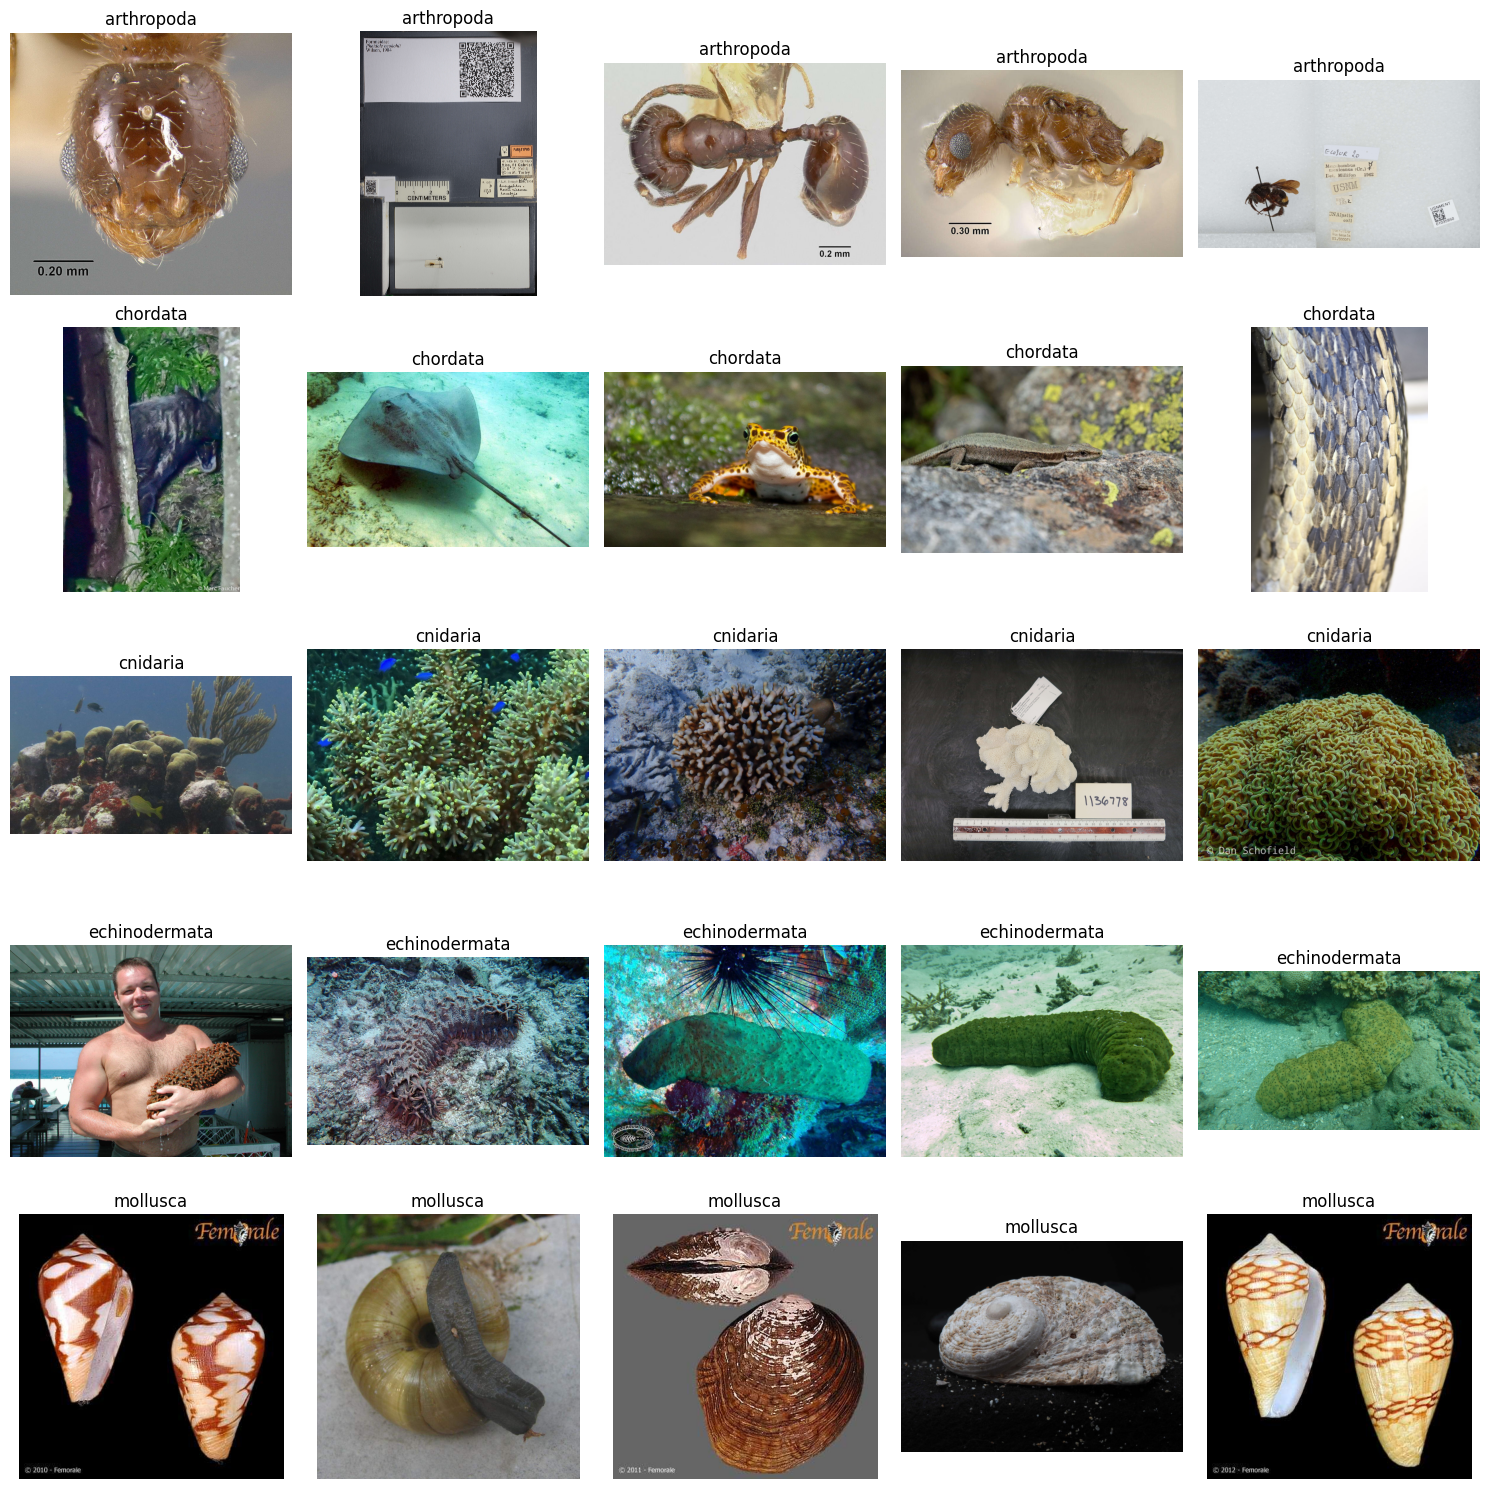

In [9]:
def show_sample_images_by_phylum(df, image_folder, num_samples=5, figsize=(15, 15)):
    '''
    Display sample images for each phylum in a grid. 5 random samples for each phylum.
    
    Parameters:
    df (DataFrame): The DataFrame containing the metadata and image paths.
    image_folder (str): The folder containing the image files.
    num_samples (int, optional): Number of images to display for each phylum. Default is 5.
    figsize (tuple, optional): The size of the figure. Default is (15, 15).
    
    Returns:
    None (displays the plot)
    '''
    # Group by phylum and sample `num_samples` images from each phylum
    phylum_groups = df.groupby('phylum')
    
    # Determine the number of rows and columns for the grid
    num_phyla = len(phylum_groups)
    rows = num_phyla
    cols = num_samples
    
    # Create a figure with a grid layout
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    # Iterate through each phylum and display images
    for i, (phylum, group) in enumerate(phylum_groups):
        # Sample images for the current phylum
        sample_df = group.sample(min(num_samples, len(group)))
        
        for j, (_, row) in enumerate(sample_df.iterrows()):
            img_path = os.path.join(image_folder, row['file_path'])
            ax = axes[i, j] if num_phyla > 1 else axes[j]
            
            if os.path.exists(img_path):
                image = Image.open(img_path)
                ax.imshow(image)
                ax.set_title(f'{row["phylum"]}')
            else:
                ax.set_title("Missing Image")
            ax.axis("off")
        
        # Set title for each phylum row
        axes[i, 0].set_ylabel(phylum, fontsize=12, rotation=0, labelpad=30)

    # Adjust layout for better visualization
    plt.tight_layout()
    plt.show()

show_sample_images_by_phylum(df, extract_path, num_samples=5)

We have images of varying sizes across different phyla and even within each phylum. Since we've decided to split the dataset by phylum, we will handle the rescaling accordingly for each phylum.

Additionally, there are some general preprocessing steps we can apply:

- Detect duplicate images: identify and remove any duplicate images from the dataset to ensure we don't have redundant data.

- Check RGB channels: verify the number of channels in each image, as some images may have only two channels instead of the standard three (RGB).

- Identify letters in images: implement code to detect any text (letters) present within the images.

- Identify human beings

## 4.2. Image Duplicates <a class="anchor" id="image_ duplicates"></a>

Image hashing is a technique that converts an image into a unique or near-unique value (hash) based on its visual content. This allows for quick comparison between images, even if they are slightly altered (e.g., resized or rotated). By using image hashing, we can efficiently identify duplicate or near-duplicate images in a dataset without comparing every pixel, making it a useful tool for cleaning up large image datasets and avoiding redundancy.


In [10]:
# def find_duplicate_images(df, image_folder):
#     """
#     Identify duplicate images in the dataframe based on their hash values.
    
#     Parameters:
#     df (DataFrame): The DataFrame containing the metadata and image paths.
#     image_folder (str): The folder containing the image files.
    
#     Returns:
#     duplicates (DataFrame): DataFrame containing the duplicates.
#     """
#     # Dictionary to store image hashes
#     image_hashes = {}
#     duplicates = []

#     # Iterate through the dataframe and calculate hashes for each image
#     for _, row in df.iterrows():
#         img_path = os.path.join(image_folder, row['file_path'])
        
#         if os.path.exists(img_path):
#             # Open the image
#             img = Image.open(img_path)
            
#             # Calculate the hash of the image (you can use different algorithms)
#             img_hash = imagehash.phash(img)
            
#             # Check if the hash already exists
#             if img_hash in image_hashes:
#                 # If duplicate found, add to the duplicates list
#                 duplicates.append({
#                     'original_image': image_hashes[img_hash],
#                     'duplicate_image': img_path,
#                     'hash': img_hash
#                 })
#             else:
#                 # Store the hash with the image path
#                 image_hashes[img_hash] = img_path
    
#     # Convert duplicates list to DataFrame for better visualization
#     duplicates_df = pd.DataFrame(duplicates)
    
#     return duplicates_df

# duplicates_df = find_duplicate_images(df, extract_path)
# if not duplicates_df.empty:
#     print("Found duplicates:")
#     print(duplicates_df)
# else:
#     print("No duplicates found.")

In [11]:
df

,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
rare_species_id,,,,,,
75fd91cb-2881-41cd-88e6-de451e8b60e2,12853737,449393,animalia,mollusca,unionidae,mollusca_unionidae/12853737_449393_eol-full-si...
28c508bc-63ff-4e60-9c8f-1934367e1528,20969394,793083,animalia,chordata,geoemydidae,chordata_geoemydidae/20969394_793083_eol-full-...
00372441-588c-4af8-9665-29bee20822c0,28895411,319982,animalia,chordata,cryptobranchidae,chordata_cryptobranchidae/28895411_319982_eol-...
29cc6040-6af2-49ee-86ec-ab7d89793828,29658536,45510188,animalia,chordata,turdidae,chordata_turdidae/29658536_45510188_eol-full-s...
94004bff-3a33-4758-8125-bf72e6e57eab,21252576,7250886,animalia,chordata,indriidae,chordata_indriidae/21252576_7250886_eol-full-s...
...,...,...,...,...,...,...
1fa96ea5-32fa-4a25-b8d2-fa99f6e2cb89,29734618,1011315,animalia,chordata,leporidae,chordata_leporidae/29734618_1011315_eol-full-s...
628bf2b4-6ecc-4017-a8e6-4306849e0cfc,29972861,1056842,animalia,chordata,emydidae,chordata_emydidae/29972861_1056842_eol-full-si...
0ecfdec9-b1cd-4d43-96fc-2f8889ec1ad9,30134195,52572074,animalia,chordata,dasyatidae,chordata_dasyatidae/30134195_52572074_eol-full...


In [12]:
# def find_duplicate_images(df, image_folder):
#     """
#     Find image duplicates in a dataset using perceptual hash (pHash).
#     Also includes the ID of the original image.

#     Parameters:
#     - df: DataFrame with at least 'file_path' and 'rare_species_id' as the index.
#     - image_folder: base folder where all images are stored.

#     Returns:
#     - duplicates_df: DataFrame with original, duplicate, hash, and original image ID.
#     """

#     # Temporarily reset the index so we can use 'rare_species_id' as a column
#     df_reset = df.reset_index()

#     image_hashes = {}  # hash -> original image path
#     id_lookup = dict(zip(df_reset['file_path'], df_reset['rare_species_id']))  # file_path -> ID
#     duplicates = []

#     for _, row in df_reset.iterrows():
#         file_path = row['file_path']
#         full_path = os.path.join(image_folder, file_path)

#         if os.path.exists(full_path):
#             try:
#                 img = Image.open(full_path)
#                 img_hash = imagehash.phash(img)

#                 if img_hash in image_hashes:
#                     original_path = image_hashes[img_hash]
#                     original_id = id_lookup.get(original_path)

#                     duplicates.append({
#                         "original_image": original_path,
#                         "original_image_id": original_id,
#                         "duplicate_image": file_path,
#                         "hash": str(img_hash)
#                     })
#                 else:
#                     image_hashes[img_hash] = file_path

#             except Exception as e:
#                 print(f"Couldn't process image {full_path}: {e}")

#     # Return to the original index structure after processing
#     return pd.DataFrame(duplicates)

# # Example usage:
# duplicates_df = find_duplicate_images(df, extract_path)

# if not duplicates_df.empty:
#     print("Found duplicates:")
#     display(duplicates_df)
# else:
#     print("No duplicates found!")

Let's store the DataFrame in our repository to avoid re-running the code every time, as it takes around 10 minutes to execute. This will make our workflow more efficient.

In [13]:
# # Save the DataFrame to a CSV file in the repository
# duplicates_df.to_csv("duplicates.csv", index=False)

In [14]:
# Load the DataFrame from the CSV file
duplicates_df = pd.read_csv("duplicates.csv")
duplicates_df.head(3)

,original_image,original_image_id,duplicate_image,hash
0,arthropoda_formicidae/29638873_889096_eol-full...,29e1f2d0-2665-470e-9f94-c76c888c4794,arthropoda_formicidae/14647056_889096_eol-full...,bb8794da4aa58c8e
1,arthropoda_formicidae/29638449_476649_eol-full...,75fda7d5-8831-4b27-98af-5ec5c877fcd6,arthropoda_formicidae/14608600_476649_eol-full...,8b2a74e13a33e58e
2,echinodermata_stichopodidae/22180228_2984557_e...,e78fbc7d-5cdd-4a16-b626-bad34ffd0d32,echinodermata_stichopodidae/14048637_2984557_e...,985ad0340fb53d8f


We looked into the list of possible duplicate images that were flagged using perceptual hashing. To double-check, we opened them side by side and reviewed them manually.

In [15]:
# for index, row in duplicates_df.iterrows():
#     original_image_path = os.path.join(extract_path, row['original_image'])
#     duplicate_image_path = os.path.join(extract_path, row['duplicate_image'])

#     # Extract phylum and family from the file path
#     phylum_family = os.path.dirname(row['original_image']).split(os.sep)[-1]

#     try:
#         # Open images
#         original_image = Image.open(original_image_path)
#         duplicate_image = Image.open(duplicate_image_path)
        
#         # Create side-by-side plot
#         fig, axes = plt.subplots(1, 2, figsize=(6, 3))
#         fig.suptitle(f"Phylum_Family: {phylum_family}", fontsize=8, fontweight="bold")

#         axes[0].imshow(original_image)
#         axes[0].axis("off")
#         axes[0].set_title("Original")

#         axes[1].imshow(duplicate_image)
#         axes[1].axis("off")
#         axes[1].set_title("Duplicate")

#         plt.show()
    
#     except Exception as e:
#         print(f"Error opening images: {e}")


Most were clearly duplicates and safe to remove — except for a few in the `arthropoda_apidae` group. These turned out to show different individuals or slightly different scenes, so we decided to keep them.

We're now removing all the real duplicates, but keeping the ones from `arthropoda_apidae` since they're not actually identical. This will help clean up the dataset without losing meaningful data.

In [16]:
df.head(3)

,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
rare_species_id,,,,,,
75fd91cb-2881-41cd-88e6-de451e8b60e2,12853737,449393,animalia,mollusca,unionidae,mollusca_unionidae/12853737_449393_eol-full-si...
28c508bc-63ff-4e60-9c8f-1934367e1528,20969394,793083,animalia,chordata,geoemydidae,chordata_geoemydidae/20969394_793083_eol-full-...
00372441-588c-4af8-9665-29bee20822c0,28895411,319982,animalia,chordata,cryptobranchidae,chordata_cryptobranchidae/28895411_319982_eol-...


In [17]:
duplicates_df

,original_image,original_image_id,duplicate_image,hash
0,arthropoda_formicidae/29638873_889096_eol-full...,29e1f2d0-2665-470e-9f94-c76c888c4794,arthropoda_formicidae/14647056_889096_eol-full...,bb8794da4aa58c8e
1,arthropoda_formicidae/29638449_476649_eol-full...,75fda7d5-8831-4b27-98af-5ec5c877fcd6,arthropoda_formicidae/14608600_476649_eol-full...,8b2a74e13a33e58e
2,echinodermata_stichopodidae/22180228_2984557_e...,e78fbc7d-5cdd-4a16-b626-bad34ffd0d32,echinodermata_stichopodidae/14048637_2984557_e...,985ad0340fb53d8f
3,chordata_fringillidae/22375404_45518969_eol-fu...,83bfc50b-1b1d-4623-980b-64a604a2c11b,chordata_fringillidae/2745972_45518969_eol-ful...,9e43537a39a3642d
4,chordata_cercopithecidae/28745816_311183_eol-f...,57f1736a-01ff-4e42-82cb-4ffc41f37e41,chordata_cercopithecidae/11765_311183_eol-full...,bcc3d1191a7769c8
...,...,...,...,...
156,mollusca_unionidae/2744856_449459_eol-full-siz...,b45830ce-7ed2-4d63-9441-409b6b9522d8,mollusca_unionidae/21566265_449459_eol-full-si...,9cc4206ef9e38795
157,chordata_iguanidae/2833161_47044557_eol-full-s...,c1279f44-d986-472e-a8c9-17b607c3a9ff,chordata_iguanidae/22552392_47044557_eol-full-...,b1ccce73e4c89386
158,chordata_chelidae/12203_2815879_eol-full-size-...,a83c534e-0091-4ee5-9d5a-136321127425,chordata_chelidae/28754499_2815879_eol-full-si...,e13f9ec392d06836
159,chordata_chamaeleonidae/29608272_1286909_eol-f...,9cf98fc0-9e34-4a25-9a40-713d4b55d881,chordata_chamaeleonidae/29608263_1286909_eol-f...,c698616795378db8


In [18]:
# Creating a copy of the original DataFrame to remove duplicates
df_no_duplicates = df.copy()

# Loop through the detected duplicates
for index, row in duplicates_df.iterrows():
    duplicate_path = row['duplicate_image']
    phylum_family = os.path.dirname(duplicate_path).split(os.sep)[-1]

    # Only drop the row if the duplicate is not from arthropoda_apidae
    if phylum_family != "arthropoda_apidae":
        df_no_duplicates = df_no_duplicates[df_no_duplicates['file_path'] != duplicate_path]
        print(f"Dropped row for: {duplicate_path}")
    else:
        print(f"Kept (not a real duplicate): {duplicate_path}")

Dropped row for: arthropoda_formicidae/14647056_889096_eol-full-size-copy.jpg
Dropped row for: arthropoda_formicidae/14608600_476649_eol-full-size-copy.jpg
Dropped row for: echinodermata_stichopodidae/14048637_2984557_eol-full-size-copy.jpg
Dropped row for: chordata_fringillidae/2745972_45518969_eol-full-size-copy.jpg
Dropped row for: chordata_cercopithecidae/11765_311183_eol-full-size-copy.jpg
Dropped row for: chordata_vangidae/16228_45514240_eol-full-size-copy.jpg
Dropped row for: echinodermata_stichopodidae/14048636_2984557_eol-full-size-copy.jpg
Dropped row for: arthropoda_formicidae/14668792_620300_eol-full-size-copy.jpg
Dropped row for: chordata_balistidae/5001_46570656_eol-full-size-copy.jpg
Dropped row for: chordata_elapidae/29473740_1055803_eol-full-size-copy.jpg
Dropped row for: chordata_trochilidae/28769504_45512248_eol-full-size-copy.jpg
Dropped row for: chordata_fringillidae/2745975_45518969_eol-full-size-copy.jpg
Dropped row for: arthropoda_coenagrionidae/2729380_1001090_

In [19]:
#Lets check that were deleted 161-2 images
#Print the shape of the DataFrame before and after removing duplicates
print("Original DataFrame shape:", df.shape)
print("DataFrame shape after removing duplicates:", df_no_duplicates.shape)

Original DataFrame shape: (11983, 6)
DataFrame shape after removing duplicates: (11824, 6)


In [20]:
df.shape[0]-df_no_duplicates.shape[0]

159

In [21]:
df_no_duplicates.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11824 entries, 75fd91cb-2881-41cd-88e6-de451e8b60e2 to 54894a59-151f-4814-ac32-3a336841e58e
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   eol_content_id  11824 non-null  int64 
 1   eol_page_id     11824 non-null  int64 
 2   kingdom         11824 non-null  object
 3   phylum          11824 non-null  object
 4   family          11824 non-null  object
 5   file_path       11824 non-null  object
dtypes: int64(2), object(4)
memory usage: 646.6+ KB


## 4.3. Channels <a class="anchor" id="image_ channels"></a>
Let's first check that they are all in the same 

In [22]:
def check_image_channels(df, image_folder):
    """
    Check the number of channels for each image in the dataset.
    
    Parameters:
    df (DataFrame): The DataFrame containing image metadata.
    image_folder (str): The folder where the images are stored.
    
    Returns:
    None (prints out images with a different number of channels)
    """
    for _, row in df.iterrows():
        img_path = os.path.join(image_folder, row['file_path'])
        if os.path.exists(img_path):
            try:
                image = Image.open(img_path)
                mode = image.mode
                channels = len(mode)  # For 'RGB' it will return 3, for 'L' it will return 1 (grayscale)
                
                if channels != 3:  # If the number of channels is not 3 (RGB)
                    print(f"Image {img_path} has {channels} channels (mode: {mode})")
            except Exception as e:
                print(f"Error with image {img_path}: {e}")

check_image_channels(df_no_duplicates, "path_to_your_image_folder")

# 5. Train Val Test Split  <a class="anchor" id="train_test_split"></a>

In [23]:
train, test = train_test_split(df_no_duplicates, test_size=0.2, random_state=42, stratify=df_no_duplicates['family'])

print(f"Train samples: {len(train)}, Val samples: {len(test)}, Test samples: {len(test)}")

Train samples: 9459, Val samples: 2365, Test samples: 2365


# 6. Models (Pre-trained)

## 6.1 Arthropoda

## 6.2 Chordata

### Pre-Processing

Load the test dataset that is treated with Clahe and Cleaned based on the parameters described in Phylum Chordata

In [53]:
spec = (
    TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
    TensorSpec(shape=(None,),           dtype=tf.int16)
)

chordata_test = tf.data.Dataset.load("train_test_splits/chordata_test_preprocessed", element_spec=spec)

In [54]:
chordata_test = chordata_test.map(
    lambda x, y: (x, tf.cast(y, tf.int32)),
    num_parallel_calls=tf.data.AUTOTUNE
)

### Predict

In [55]:
chordata_model = load_model("models/chordata_models/inceptionv3_best_model_clahe.keras")

In [56]:
# now you can still do:
chordata_results = chordata_model.predict(chordata_test.map(lambda x, y: x))

116/116 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step


### Results

Accuracy:  0.5353
Macro F1: 0.4538

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.41      0.53        22
           1       0.39      0.47      0.42        15
           2       0.71      0.42      0.53        12
           3       0.00      0.00      0.00         5
           4       1.00      0.50      0.67         6
           5       1.00      0.20      0.33         5
           6       0.50      0.18      0.27        11
           7       0.25      0.27      0.26        11
           8       0.72      0.53      0.61        34
           9       0.47      0.67      0.55        12
          10       1.00      0.25      0.40         4
          11       0.32      0.50      0.39        12
          12       0.67      0.33      0.44         6
          13       0.60      0.52      0.56        23
          14       0.00      0.00      0.00         4
          15       0.00      0.00      0.00         6
          16       0.3

/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

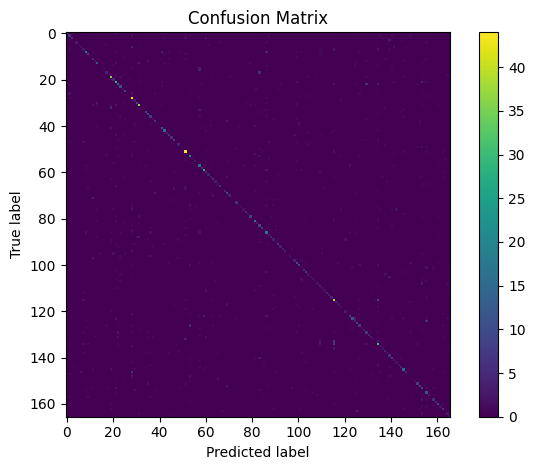

In [57]:

# 1) Get predicted class indices
y_pred = np.argmax(chordata_results, axis=1)

# 2) Extract true labels from your tf.data.Dataset
y_true = np.concatenate([
    y_batch.numpy() 
    for _, y_batch in chordata_test
], axis=0)

# 3) Compute metrics
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')  # or 'macro' depending on your class‐balance

print(f"Accuracy:  {acc:.4f}")
print(f"Macro F1: {f1:.4f}\n")
print("Classification Report:")
print(classification_report(y_true, y_pred))

# 4) Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 5) Plot it
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest')
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
fig.colorbar(im, ax=ax)

# Optionally add tick labels if you have class names:
# class_names = ['ClassA','ClassB',...]
# ax.set_xticks(np.arange(len(class_names)))
# ax.set_yticks(np.arange(len(class_names)))
# ax.set_xticklabels(class_names, rotation=45, ha="right")
# ax.set_yticklabels(class_names)

plt.tight_layout()
plt.show()

## 6.3 Cnidaria

### Pre-processing

Loading the test data set treated with CLAHE

In [20]:
cnidaria_test = pd.read_pickle("train_test_splits/cnidaria_test_processed.pkl")

Implementing MobileNetV2 specific pre-processing and creating tensorflow dataset

In [21]:
cnidaria_test = cnidaria_preprocess(cnidaria_test)

### Predict

In [ ]:


cnidaria_model = load_model("models/cnidaria_models/mobilenetV2_final.keras")

In [23]:
cnidaria_results = cnidaria_model.predict(cnidaria_test)

I0000 00:00:1746012962.838690  317781 service.cc:152] XLA service 0x7fa848004f50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746012962.838862  317781 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2025-04-30 12:36:02.881001: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746012963.353833  317781 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-04-30 12:36:03.851717: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1152', 8 bytes spill stores, 8 bytes spill loads

2025-04-30 12:36:03.863404: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1152', 

16/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

I0000 00:00:1746012971.715047  317781 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-04-30 12:36:14.653125: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1152', 12 bytes spill stores, 12 bytes spill loads

2025-04-30 12:36:14.703521: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1152', 8 bytes spill stores, 8 bytes spill loads

2025-04-30 12:36:15.028464: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1152_0', 184 bytes spill stores, 520 bytes spill loads

2025-04-30 12:36:15.083564: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : R

21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 550ms/step


### Results

Accuracy:  0.1420
F1 (weighted): 0.0201

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.15      0.96      0.26        24
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        18
           5       0.00      0.00      0.00        12
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         6
          10       0.00      0.00      0.00        12
          11       0.00      0.00      0.00        12
          12       0.00      0.00      0.00         6

    accuracy                           0.14       162
   macro avg       0.01      0.07      0.02       162
weighted avg       0.02      0.14      0.04       162



2025-04-30 12:41:36.378177: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being s

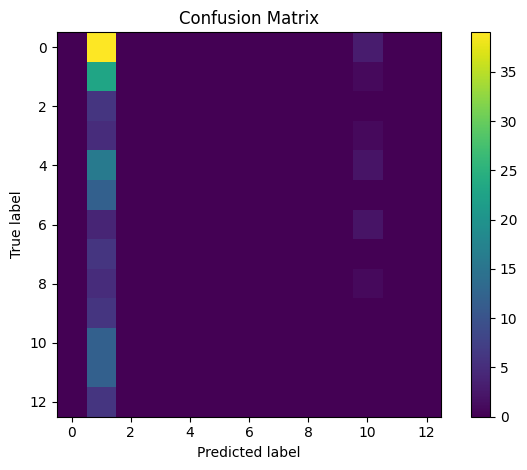

In [ ]:
# 1) Get predicted class indices
y_pred = np.argmax(cnidaria_results, axis=1)

# 2) Extract true labels from your tf.data.Dataset
#    Assumes cnidaria_test yields (image_batch, label_batch)
y_true = np.concatenate([
    y_batch.numpy() 
    for _, y_batch in cnidaria_test
], axis=0)

# 3) Compute metrics
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')  # or 'macro' depending on your class‐balance

print(f"Accuracy:  {acc:.4f}")
print(f"Macro F1: {f1:.4f}\n")
print("Classification Report:")
print(classification_report(y_true, y_pred))

# 4) Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 5) Plot it
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest')
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
fig.colorbar(im, ax=ax)

# Optionally add tick labels if you have class names:
# class_names = ['ClassA','ClassB',...]
# ax.set_xticks(np.arange(len(class_names)))
# ax.set_yticks(np.arange(len(class_names)))
# ax.set_xticklabels(class_names, rotation=45, ha="right")
# ax.set_yticklabels(class_names)

plt.tight_layout()
plt.show()

## 6.4 Mollusca

### Pre-Processing

Creating test generator like in the phylum

In [27]:
mollusca_test = pd.read_csv("train_test_splits/mollusca_test.csv")

In [28]:
mollusca_test = create_generators(mollusca_test, "rare_species")

Found 40 validated image filenames belonging to 5 classes.


### Predict

In [30]:
mollusca_model = load_model("models/mollusca_models/best_mobilenetv2.keras")

In [35]:
mollusca_results = mollusca_model.predict(mollusca_test)

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step


### Results

Accuracy: 0.8750
Macro F1: 0.8501

Classification Report:
              precision    recall  f1-score   support

   cardiidae       0.86      1.00      0.92        12
     conidae       1.00      0.83      0.91         6
  haliotidae       0.75      0.50      0.60         6
   unionidae       0.83      1.00      0.91        10
   zonitidae       1.00      0.83      0.91         6

    accuracy                           0.88        40
   macro avg       0.89      0.83      0.85        40
weighted avg       0.88      0.88      0.87        40



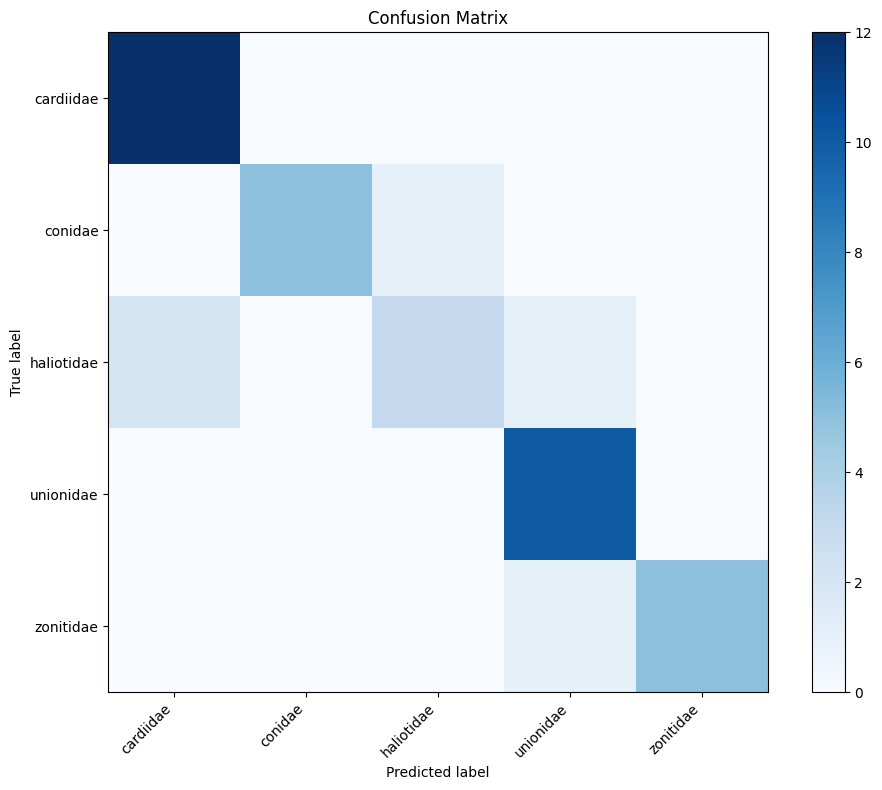

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# 1) Convert softmax scores to class indices
y_pred = np.argmax(mollusca_results, axis=1)

# 2) Extract the true labels directly from the generator
y_true = mollusca_test.classes  # shape = (n_test_samples,)

# 3) Compute metrics
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')  # or 'weighted'

print(f"Accuracy: {acc:.4f}")
print(f"Macro F1: {f1:.4f}\n")
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(mollusca_test.class_indices.keys())))

# 4) Build confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 5) Plot it
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
fig.colorbar(im, ax=ax)

# Annotate ticks with class names if you like
class_names = list(mollusca_test.class_indices.keys())
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha="right")
ax.set_yticklabels(class_names)

plt.tight_layout()
plt.show()

## 6.5 Echniodermata